In [220]:
import pandas as pd

# 1. Leer los archivos CSV
inv_df = pd.read_csv("Data/Inv.csv", sep=",")
offline_df = pd.read_csv("Data/Offline.csv", sep=",")
time_df = pd.read_csv("Data/Time.csv", sep=",")
visit_df = pd.read_csv("Data/Visit.csv", sep=",")
web_df = pd.read_csv("Data/Web.csv", sep=",")

# 2. Convertir ID_Date a datetime en todos los dataframes (YYYY-MM-01)
for df in [inv_df, offline_df, time_df, visit_df, web_df]:
    df["ID_Date"] = pd.to_datetime(df["ID_Date"], format="%Y%m")

# 3. Unir todos los datasets por ID_Date
df_combined = web_df \
    .merge(visit_df, on="ID_Date", how="left") \
    .merge(offline_df, on="ID_Date", how="left") \
    .merge(time_df, on="ID_Date", how="left") \
    .merge(inv_df, on="ID_Date", how="left")

# 4. Renombrar columna ID_Date a Fecha
df_combined.rename(columns={"ID_Date": "Fecha"}, inplace=True)

# 5. Crear columnas de eventos a nivel mensual
df_combined["Navidad"] = df_combined["Fecha"].dt.month.apply(lambda x: 1 if x == 12 else 0)
df_combined["Black_Friday"] = df_combined["Fecha"].dt.month.apply(lambda x: 1 if x == 11 else 0)
df_combined["Semana_Santa"] = df_combined["Fecha"].dt.month.apply(lambda x: 1 if x in [3, 4] else 0)

# 6. (Opcional) Formatear Fecha como YYYY-MM (para visualizar mejor en CSV)
df_combined["Fecha"] = df_combined["Fecha"].dt.strftime("%Y-%m")

print("✅ Dataset combinado y eventos añadidos correctamente (con Fecha como Año-Mes).")

✅ Dataset combinado y eventos añadidos correctamente (con Fecha como Año-Mes).


In [221]:
df_combined

,Fecha,Unique_visitors,PDFBrochuresDownloaded,ProductConfigurator,Product_configurator_Visists,SocialNetworks,DirectTraffic,EMail,NaturalSearch,OnlineMedia,...,PRENSA,PRODUCCION,RADIO,REVISTAS,PlataformasVideo,VARIOS,INV_Total,Navidad,Black_Friday,Semana_Santa
0,2022-01,272382,4838,33222,94248,1415,65373,25,167199,63649,...,0,6050,"2426,4","18013,5","338824,94","7531,030000000001","574600,14",0,0,0
1,2022-02,352581,5823,38570,109531,546,77209,26,176733,124861,...,10000,6700,0,"49110,909999999996","487537,14","6972,02","916515,0800000001",0,0,0
2,2022-03,332955,4845,33956,97805,5444,83178,341,173514,104132,...,4500,3700,0,0,75000,"15284,85","367522,47",0,0,1
3,2022-04,282169,3711,45949,90689,1184,69335,162,162805,74044,...,48800,21550,1140,40876,"610865,8899999999","12255,75","941187,9099999999",0,0,1
4,2022-05,261829,9037,48685,92069,8648,70972,210,156011,44196,...,11000,4900,"102851,86000000002","20775,75","393807,7400000001","7926,459999999999","746390,17",0,0,0
5,2022-06,201141,10727,38608,73421,1082,61455,2374,134355,15600,...,0,12250,"5526,49","75573,13",0,"5405,719999999999","203983,00000000003",0,0,0
6,2022-07,206538,11023,38912,74564,909,66835,204,144300,11000,...,0,650,"158,4",2600,1500,"4574,5","130196,56999999999",0,0,0
7,2022-08,259903,15743,47613,88335,7511,78704,14,172986,15205,...,13000,9750,"345,6",33860,"391987,8699999999","28716,26","524021,7399999999",0,0,0
8,2022-09,261618,14130,44164,83840,1773,58630,199,174125,41832,...,"9507,8",7850,"2686,8",14580,0,"6645,2699999999995","158223,58",0,0,0
9,2022-10,396642,16321,53200,100262,2117,74040,874,203699,162588,...,0,20300,3162,"117786,97","804181,4000000003","14421,129999999997","1277335,3600000003",0,0,0


In [222]:
# Reemplazar comas por puntos y convertir a numérico donde sea necesario
for col in df_combined.columns:
    if df_combined[col].dtype == 'object':
        df_combined[col] = df_combined[col].str.replace(',', '.', regex=False)
        df_combined[col] = pd.to_numeric(df_combined[col], errors='ignore')  # Solo convierte si se puede


C:\Users\aserr\AppData\Local\Temp\ipykernel_2076\700684367.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_combined[col] = pd.to_numeric(df_combined[col], errors='ignore')  # Solo convierte si se puede


In [223]:
# Guardar la columna 'Fecha' aparte
fecha_col = df_combined['Fecha']

# Convertir todo lo demás a numérico
df_combined = df_combined.drop(columns=['Fecha'])
df_combined = df_combined.apply(pd.to_numeric, errors='coerce')

# Volver a agregar la columna 'Fecha' como texto en formato "YYYY-MM"
df_combined['Fecha'] = pd.to_datetime(fecha_col).dt.strftime('%Y-%m')


C:\Users\aserr\AppData\Local\Temp\ipykernel_2076\561306165.py:16: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aserr\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


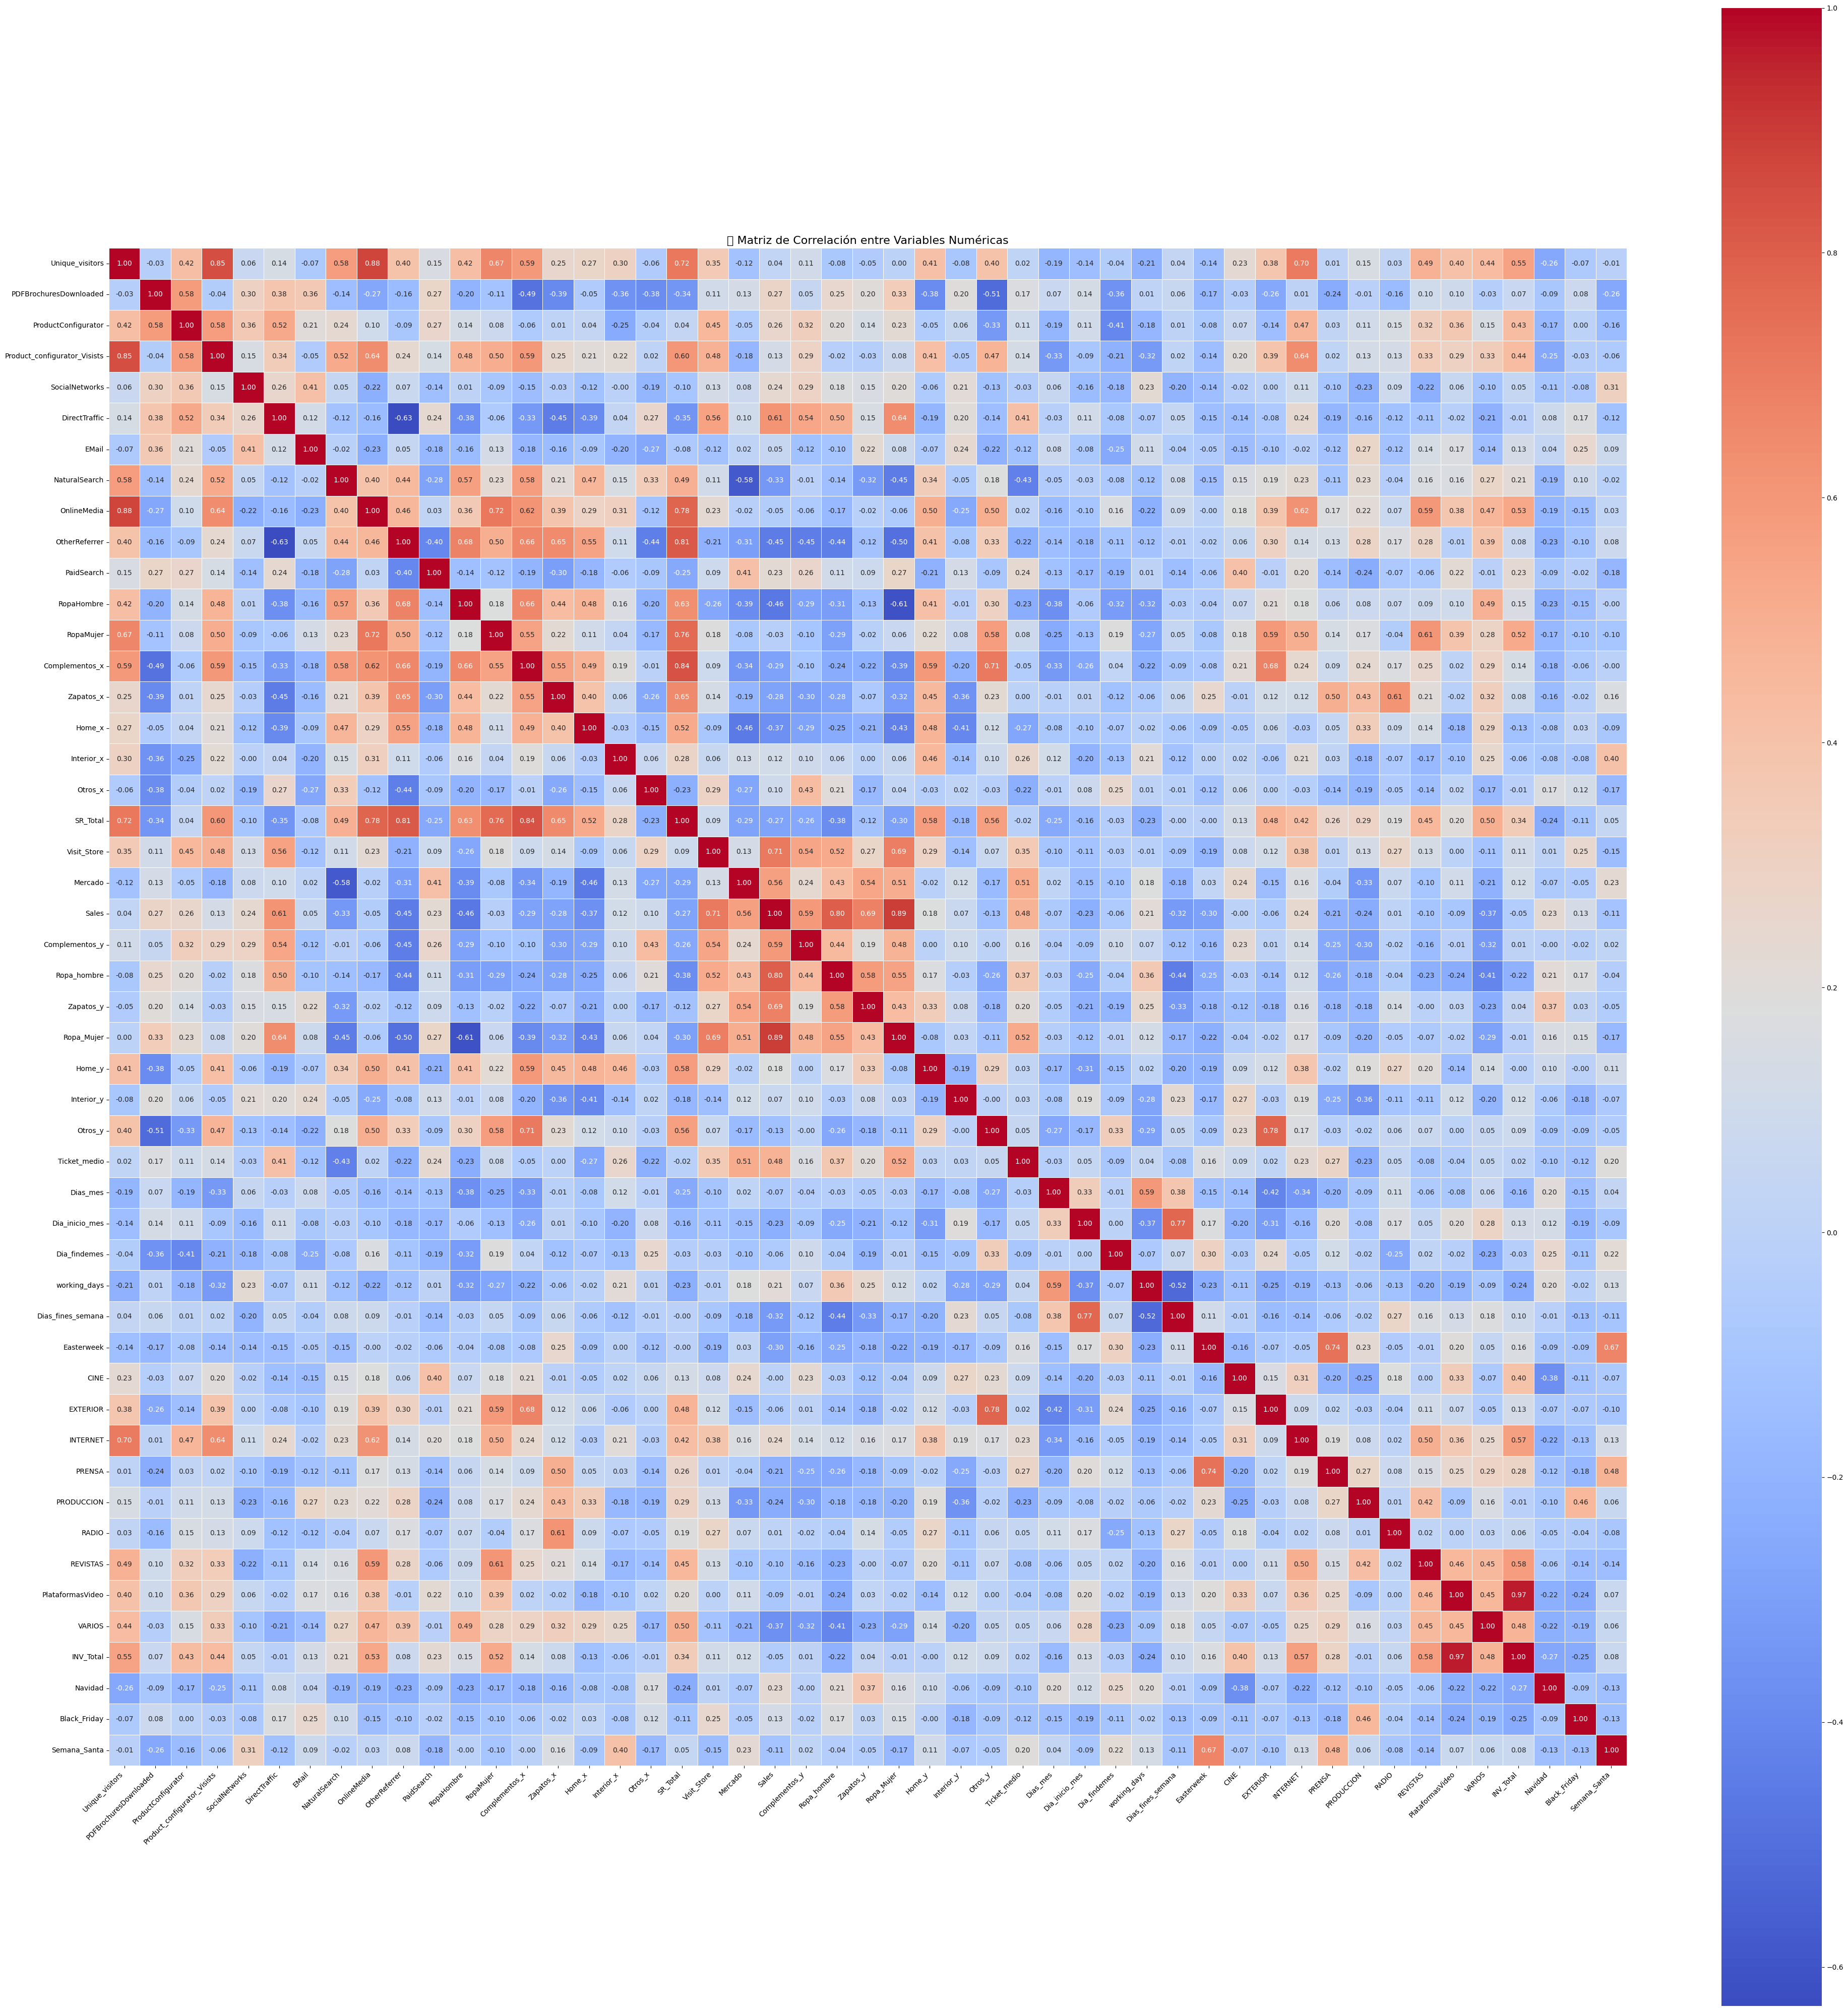

In [224]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurarse de excluir la columna 'Fecha' y usar solo numéricas
df_numericas = df_combined.select_dtypes(include='number')

# Calcular la matriz de correlación
corr = df_numericas.corr()

# Graficar la matriz con seaborn
plt.figure(figsize=(40, 40))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=.5)
plt.title("🔍 Matriz de Correlación entre Variables Numéricas", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [225]:
df_combined

,Unique_visitors,PDFBrochuresDownloaded,ProductConfigurator,Product_configurator_Visists,SocialNetworks,DirectTraffic,EMail,NaturalSearch,OnlineMedia,OtherReferrer,...,PRODUCCION,RADIO,REVISTAS,PlataformasVideo,VARIOS,INV_Total,Navidad,Black_Friday,Semana_Santa,Fecha
0,272382,4838,33222,94248,1415,65373,25,167199,63649,39808,...,6050.00,2426.40,18013.5000,338824.940,7531.0300,5.746001e+05,0,0,0,2022-01
1,352581,5823,38570,109531,546,77209,26,176733,124861,45543,...,6700.00,0.00,49110.9100,487537.140,6972.0200,9.165151e+05,0,0,0,2022-02
2,332955,4845,33956,97805,5444,83178,341,173514,104132,43583,...,3700.00,0.00,0.0000,75000.000,15284.8500,3.675225e+05,0,0,1,2022-03
3,282169,3711,45949,90689,1184,69335,162,162805,74044,39650,...,21550.00,1140.00,40876.0000,610865.890,12255.7500,9.411879e+05,0,0,1,2022-04
4,261829,9037,48685,92069,8648,70972,210,156011,44196,40472,...,4900.00,102851.86,20775.7500,393807.740,7926.4600,7.463902e+05,0,0,0,2022-05
5,201141,10727,38608,73421,1082,61455,2374,134355,15600,35272,...,12250.00,5526.49,75573.1300,0.000,5405.7200,2.039830e+05,0,0,0,2022-06
6,206538,11023,38912,74564,909,66835,204,144300,11000,35674,...,650.00,158.40,2600.0000,1500.000,4574.5000,1.301966e+05,0,0,0,2022-07
7,259903,15743,47613,88335,7511,78704,14,172986,15205,42545,...,9750.00,345.60,33860.0000,391987.870,28716.2600,5.240217e+05,0,0,0,2022-08
8,261618,14130,44164,83840,1773,58630,199,174125,41832,41167,...,7850.00,2686.80,14580.0000,0.000,6645.2700,1.582236e+05,0,0,0,2022-09
9,396642,16321,53200,100262,2117,74040,874,203699,162588,45763,...,20300.00,3162.00,117786.9700,804181.400,14421.1300,1.277335e+06,0,0,0,2022-10


In [226]:
# Seleccionar solo las columnas numéricas
df_numeric = df_combined.select_dtypes(include=['number'])

# Calcular la correlación de todas las columnas numéricas con 'Sales'
corr_sales = df_numeric.corr()['Sales'].sort_values(ascending=False)

# Mostrar la correlación con 'Sales'
print("Correlación con Sales:")
print(corr_sales)


Correlación con Sales:
Sales                           1.000000
Ropa_Mujer                      0.894943
Ropa_hombre                     0.799824
Visit_Store                     0.713005
Zapatos_y                       0.686925
DirectTraffic                   0.613117
Complementos_y                  0.590911
Mercado                         0.564543
Ticket_medio                    0.481195
PDFBrochuresDownloaded          0.274405
ProductConfigurator             0.259939
INTERNET                        0.243111
SocialNetworks                  0.239081
Navidad                         0.231766
PaidSearch                      0.225588
working_days                    0.214987
Home_y                          0.182781
Black_Friday                    0.132872
Product_configurator_Visists    0.126808
Interior_x                      0.117267
Otros_x                         0.100038
Interior_y                      0.071522
EMail                           0.051827
Unique_visitors                 0.

In [227]:
import pandas as pd

# Asegúrate de que las columnas numéricas estén bien formateadas
df_combined['Sales'] = pd.to_numeric(df_combined['Sales'], errors='coerce')
df_combined['Unique_visitors'] = pd.to_numeric(df_combined['Unique_visitors'], errors='coerce')

# Crear la variable ventas/tráfico
df_combined['Ventas_Trafico'] = df_combined['Sales'] / df_combined['Unique_visitors']
df_combined['Ventas_Trafico_Lag1'] = df_combined['Ventas_Trafico'].shift(1)

# Crear las variables rezagadas
df_combined['Ventas_Lag1'] = df_combined['Sales'].shift(1)
df_combined['Trafico_Lag1'] = df_combined['Unique_visitors'].shift(1)

# Crear otras variables como el crecimiento de ventas y tráfico
df_combined['Crecimiento_Ventas'] = (df_combined['Sales'] - df_combined['Ventas_Lag1']) / df_combined['Ventas_Lag1']
df_combined['Crecimiento_Trafico'] = (df_combined['Unique_visitors'] - df_combined['Trafico_Lag1']) / df_combined['Trafico_Lag1']

# Eliminar filas con NaN (por los lags)
df_combined.dropna(inplace=True)


In [228]:
df_combined

,Unique_visitors,PDFBrochuresDownloaded,ProductConfigurator,Product_configurator_Visists,SocialNetworks,DirectTraffic,EMail,NaturalSearch,OnlineMedia,OtherReferrer,...,Navidad,Black_Friday,Semana_Santa,Fecha,Ventas_Trafico,Ventas_Trafico_Lag1,Ventas_Lag1,Trafico_Lag1,Crecimiento_Ventas,Crecimiento_Trafico
1,352581,5823,38570,109531,546,77209,26,176733,124861,45543,...,0,0,0,2022-02,0.004969,0.004769,1299.0,272382.0,0.348730,0.294436
2,332955,4845,33956,97805,5444,83178,341,173514,104132,43583,...,0,0,1,2022-03,0.005697,0.004969,1752.0,352581.0,0.082763,-0.055664
3,282169,3711,45949,90689,1184,69335,162,162805,74044,39650,...,0,0,1,2022-04,0.005479,0.005697,1897.0,332955.0,-0.185029,-0.152531
4,261829,9037,48685,92069,8648,70972,210,156011,44196,40472,...,0,0,0,2022-05,0.006814,0.005479,1546.0,282169.0,0.153946,-0.072084
5,201141,10727,38608,73421,1082,61455,2374,134355,15600,35272,...,0,0,0,2022-06,0.009038,0.006814,1784.0,261829.0,0.019058,-0.231785
6,206538,11023,38912,74564,909,66835,204,144300,11000,35674,...,0,0,0,2022-07,0.007664,0.009038,1818.0,201141.0,-0.129263,0.026832
7,259903,15743,47613,88335,7511,78704,14,172986,15205,42545,...,0,0,0,2022-08,0.004394,0.007664,1583.0,206538.0,-0.278585,0.258379
8,261618,14130,44164,83840,1773,58630,199,174125,41832,41167,...,0,0,0,2022-09,0.005890,0.004394,1142.0,259903.0,0.349387,0.006599
9,396642,16321,53200,100262,2117,74040,874,203699,162588,45763,...,0,0,0,2022-10,0.003999,0.005890,1541.0,261618.0,0.029202,0.516111
10,249824,12549,41706,80311,1718,67089,4366,179778,17594,42170,...,0,1,0,2022-11,0.006252,0.003999,1586.0,396642.0,-0.015132,-0.370152


In [229]:
'''from sklearn.preprocessing import MinMaxScaler

# Lista de columnas a escalar
cols_to_scale = ['CINE', 'EXTERIOR', 'INTERNET', 'PRENSA', 'PRODUCCION', 'RADIO', 'REVISTAS', 'PlataformasVideo', 'VARIOS']

# Filtrar solo las que realmente existen en el DataFrame (por si acaso alguna faltara)
cols_to_scale = [col for col in cols_to_scale if col in df_combined.columns]

# Aplicar MinMaxScaler
scaler = MinMaxScaler()
df_combined[cols_to_scale] = scaler.fit_transform(df_combined[cols_to_scale])

print("✅ Columnas seleccionadas escaladas correctamente.")
'''

'from sklearn.preprocessing import MinMaxScaler\n\n# Lista de columnas a escalar\ncols_to_scale = [\'CINE\', \'EXTERIOR\', \'INTERNET\', \'PRENSA\', \'PRODUCCION\', \'RADIO\', \'REVISTAS\', \'PlataformasVideo\', \'VARIOS\']\n\n# Filtrar solo las que realmente existen en el DataFrame (por si acaso alguna faltara)\ncols_to_scale = [col for col in cols_to_scale if col in df_combined.columns]\n\n# Aplicar MinMaxScaler\nscaler = MinMaxScaler()\ndf_combined[cols_to_scale] = scaler.fit_transform(df_combined[cols_to_scale])\n\nprint("✅ Columnas seleccionadas escaladas correctamente.")\n'

In [230]:
df_combined

,Unique_visitors,PDFBrochuresDownloaded,ProductConfigurator,Product_configurator_Visists,SocialNetworks,DirectTraffic,EMail,NaturalSearch,OnlineMedia,OtherReferrer,...,Navidad,Black_Friday,Semana_Santa,Fecha,Ventas_Trafico,Ventas_Trafico_Lag1,Ventas_Lag1,Trafico_Lag1,Crecimiento_Ventas,Crecimiento_Trafico
1,352581,5823,38570,109531,546,77209,26,176733,124861,45543,...,0,0,0,2022-02,0.004969,0.004769,1299.0,272382.0,0.348730,0.294436
2,332955,4845,33956,97805,5444,83178,341,173514,104132,43583,...,0,0,1,2022-03,0.005697,0.004969,1752.0,352581.0,0.082763,-0.055664
3,282169,3711,45949,90689,1184,69335,162,162805,74044,39650,...,0,0,1,2022-04,0.005479,0.005697,1897.0,332955.0,-0.185029,-0.152531
4,261829,9037,48685,92069,8648,70972,210,156011,44196,40472,...,0,0,0,2022-05,0.006814,0.005479,1546.0,282169.0,0.153946,-0.072084
5,201141,10727,38608,73421,1082,61455,2374,134355,15600,35272,...,0,0,0,2022-06,0.009038,0.006814,1784.0,261829.0,0.019058,-0.231785
6,206538,11023,38912,74564,909,66835,204,144300,11000,35674,...,0,0,0,2022-07,0.007664,0.009038,1818.0,201141.0,-0.129263,0.026832
7,259903,15743,47613,88335,7511,78704,14,172986,15205,42545,...,0,0,0,2022-08,0.004394,0.007664,1583.0,206538.0,-0.278585,0.258379
8,261618,14130,44164,83840,1773,58630,199,174125,41832,41167,...,0,0,0,2022-09,0.005890,0.004394,1142.0,259903.0,0.349387,0.006599
9,396642,16321,53200,100262,2117,74040,874,203699,162588,45763,...,0,0,0,2022-10,0.003999,0.005890,1541.0,261618.0,0.029202,0.516111
10,249824,12549,41706,80311,1718,67089,4366,179778,17594,42170,...,0,1,0,2022-11,0.006252,0.003999,1586.0,396642.0,-0.015132,-0.370152


### Modelossss

In [231]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

# VARIABLES
variables_inversion = ['CINE','EXTERIOR','INTERNET','PRENSA','PRODUCCION',
                       'RADIO','REVISTAS','PlataformasVideo','VARIOS']

variables_eventos = ['Navidad', 'Black_Friday', 'Semana_Santa']

variables_temporales = ['Ventas_Trafico', 'Ventas_Trafico_Lag1', 'Ventas_Lag1',
                        'Trafico_Lag1', 'Crecimiento_Ventas', 'Crecimiento_Trafico']

# X: variables predictoras
X = df_combined[variables_inversion + variables_eventos + variables_temporales].copy()

# y: variable objetivo
y = df_combined['Sales'].copy()

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# MODELOS
modelos = {
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5)
}

resultados = {}

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    resultados[nombre] = {
        "modelo": modelo,
        "RMSE": rmse,
        "R2": r2,
        "Coeficientes": pd.Series(modelo.coef_, index=X.columns)
    }

# MOSTRAR RESULTADOS
for nombre, datos in resultados.items():
    print(f"\n🔹 Modelo: {nombre}")
    print(f"RMSE: {datos['RMSE']:.2f}")
    print(f"R²: {datos['R2']:.2f}")
    print("Coeficientes relevantes (≠ 0):")
    coef_no_cero = datos['Coeficientes'][datos['Coeficientes'] != 0]
    print(coef_no_cero.sort_values(ascending=False))

# Elegir el mejor (por R²)
mejor_modelo = max(resultados.items(), key=lambda x: x[1]['R2'])
print(f"\n🏆 Mejor modelo: {mejor_modelo[0]} con R² = {mejor_modelo[1]['R2']:.2f}")



🔹 Modelo: Ridge
RMSE: 76.57
R²: 0.91
Coeficientes relevantes (≠ 0):
Ventas_Trafico         175.689163
Crecimiento_Ventas     153.794767
Ventas_Lag1            112.434657
Crecimiento_Trafico    105.581004
Trafico_Lag1            87.451356
INTERNET                54.858299
Semana_Santa            14.973243
Black_Friday            10.508868
RADIO                   10.304885
Ventas_Trafico_Lag1      8.647738
EXTERIOR                 5.130570
Navidad                  2.550414
CINE                    -4.915259
REVISTAS                -5.565548
VARIOS                  -5.746911
PlataformasVideo        -6.075421
PRENSA                  -9.423412
PRODUCCION             -30.992749
dtype: float64

🔹 Modelo: Lasso
RMSE: 83.87
R²: 0.90
Coeficientes relevantes (≠ 0):
Ventas_Trafico         236.593092
Crecimiento_Trafico    204.286825
Ventas_Lag1            155.191909
Crecimiento_Ventas     133.540298
Trafico_Lag1            96.013079
Semana_Santa            14.297781
INTERNET                12.8092

### Optimizacion pa

In [232]:
from scipy.optimize import minimize

# Obtener el modelo ganador
modelo_ganador = mejor_modelo[1]['modelo']
coeficientes = mejor_modelo[1]['Coeficientes'].copy()

# Extraer solo los coeficientes de inversión (importante)
coef_inversion = coeficientes[variables_inversion].values
n_canales = len(variables_inversion)

# Presupuesto disponible: media de INV_Total
presupuesto_total = df_combined['INV_Total'].mean()

# Función objetivo (negativa porque 'minimize' quiere minimizar)
def objetivo(x):
    return -np.dot(coef_inversion, x)

# Restricción: no superar el presupuesto total
def restriccion_presupuesto(x):
    return presupuesto_total - np.sum(x)

# Cotas: inversión mínima 0 (no negativa)
bounds = [(0, None) for _ in range(n_canales)]

# Inicialización: repartir presupuesto equitativamente
x0 = np.repeat(presupuesto_total / n_canales, n_canales)

# Optimización con restricciones
res = minimize(
    objetivo,
    x0,
    method='SLSQP',
    bounds=bounds,
    constraints=[{'type': 'ineq', 'fun': restriccion_presupuesto}]
)

# Mostrar resultados
print("\n📊 Asignación óptima de presupuesto:")
for canal, valor in zip(variables_inversion, res.x):
    print(f"{canal}: {valor:.2f} €")

print(f"\n💰 Presupuesto total usado: {np.sum(res.x):.2f} € de un máximo de {presupuesto_total:.2f} €")
print(f"📈 Ventas esperadas (estimadas): {-res.fun:.2f}")



📊 Asignación óptima de presupuesto:
CINE: 13.44 €
EXTERIOR: 512.69 €
INTERNET: 184468822.79 €
PRENSA: 24219.57 €
PRODUCCION: 91970.50 €
RADIO: 376375.41 €
REVISTAS: 148511.83 €
PlataformasVideo: 99454.10 €
VARIOS: 1.98 €

💰 Presupuesto total usado: 185209882.32 € de un máximo de 576562.06 €
📈 Ventas esperadas (estimadas): 10119017553.59



📊 Asignación óptima de presupuesto con mínimos:
CINE: 28828.10 € (5.00%)
EXTERIOR: 23062.48 € (4.00%)
INTERNET: 438187.17 € (76.00%)
PRENSA: 0.00 € (0.00%)
PRODUCCION: 17296.86 € (3.00%)
RADIO: 57656.21 € (10.00%)
REVISTAS: 0.00 € (0.00%)
PlataformasVideo: 0.00 € (0.00%)
VARIOS: 11531.24 € (2.00%)

💰 Total invertido: 576562.06 € (presupuesto disponible: 576562.06 €)
📈 Ventas estimadas: 24006623.22


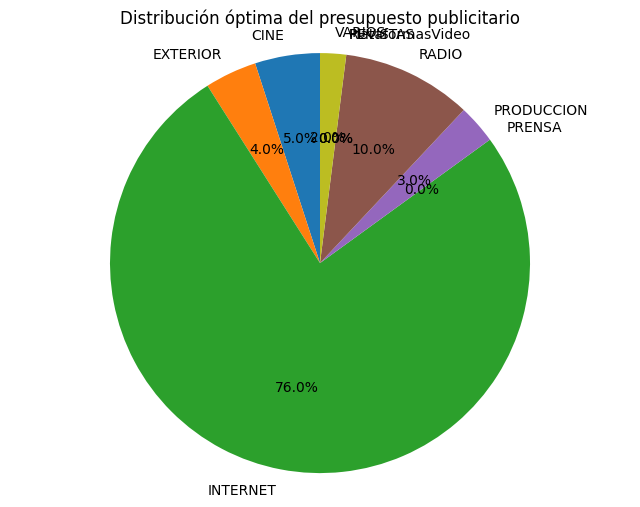

In [233]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Lista de canales y coeficientes del mejor modelo
coeficientes = mejor_modelo[1]['Coeficientes'].copy()
coef_inversion = coeficientes[variables_inversion].values
n_canales = len(variables_inversion)
presupuesto_total = df_combined['INV_Total'].mean()

# Índices por grupo
grupo_basicos = [variables_inversion.index(c) for c in ['PRENSA', 'RADIO', 'REVISTAS']]
grupo_cine_video = [variables_inversion.index(c) for c in ['CINE', 'PlataformasVideo']]
grupo_varios = [variables_inversion.index('VARIOS')]
grupo_produccion = [variables_inversion.index('PRODUCCION')]
grupo_exterior = [variables_inversion.index('EXTERIOR')]

# Restricciones de mínimos por grupo
minimos_por_grupo = [
    (grupo_basicos, 0.10),
    (grupo_cine_video, 0.05),
    (grupo_varios, 0.02),
    (grupo_produccion, 0.03),
    (grupo_exterior, 0.04)
]

# Función objetivo
def objetivo(x):
    return -np.dot(coef_inversion, x)

# Restricción total de presupuesto
restriccion_total = {'type': 'eq', 'fun': lambda x: np.sum(x) - presupuesto_total}

# Restricciones de mínimos por grupo
restricciones = [restriccion_total]
for indices, porcentaje in minimos_por_grupo:
    restricciones.append({
        'type': 'ineq',
        'fun': lambda x, idx=indices, pct=porcentaje: np.sum(x[idx]) - (pct * presupuesto_total)
    })

# Cotas: 0 a sin límite (aunque el presupuesto total las limita)
bounds = [(0, None) for _ in range(n_canales)]

# Punto inicial: reparto equitativo
x0 = np.repeat(presupuesto_total / n_canales, n_canales)

# Optimizar
res = minimize(objetivo, x0, method='SLSQP', bounds=bounds, constraints=restricciones)

# Resultados
asignacion = res.x
porcentajes = asignacion / presupuesto_total * 100

print("\n📊 Asignación óptima de presupuesto con mínimos:")
for canal, valor, porc in zip(variables_inversion, asignacion, porcentajes):
    print(f"{canal}: {valor:.2f} € ({porc:.2f}%)")

print(f"\n💰 Total invertido: {np.sum(asignacion):.2f} € (presupuesto disponible: {presupuesto_total:.2f} €)")
print(f"📈 Ventas estimadas: {-res.fun:.2f}")

# Diagrama de pastel
plt.figure(figsize=(8, 6))
plt.pie(asignacion, labels=variables_inversion, autopct='%1.1f%%', startangle=90)
plt.title("Distribución óptima del presupuesto publicitario")
plt.axis('equal')  # Círculo perfecto
plt.show()


### Comparativa

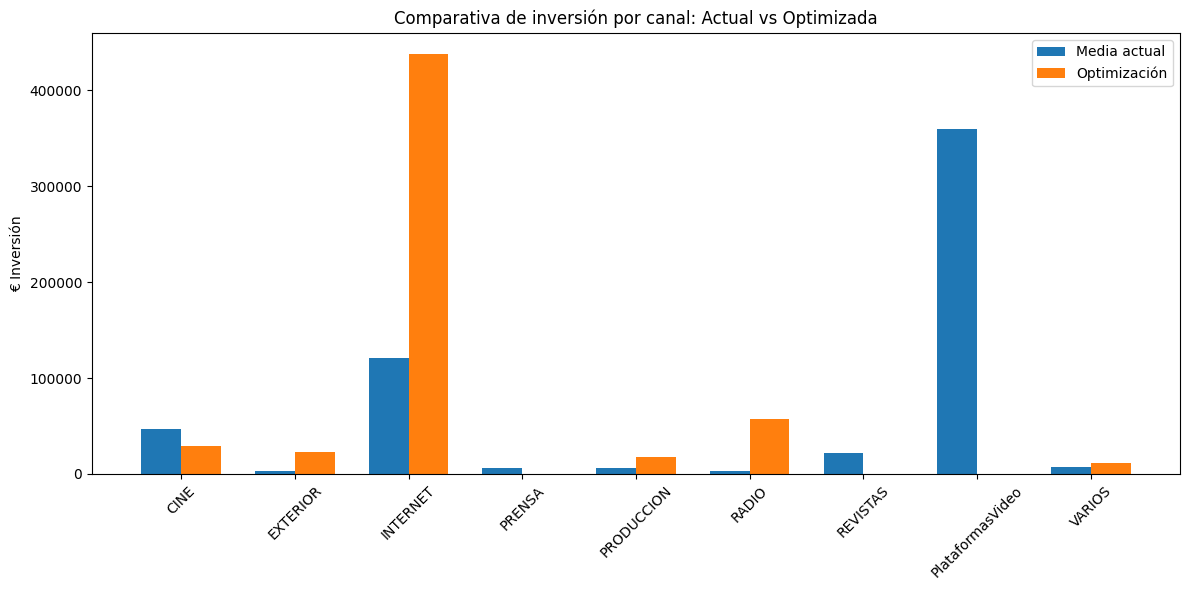

In [234]:
import matplotlib.pyplot as plt
import numpy as np

# Media de gasto actual por canal
media_inversion_actual = df_combined[variables_inversion].mean().values

# Inversión óptima (calculada previamente con res.x)
inversion_optima = res.x

# Crear gráfico de barras comparativo
x = np.arange(len(variables_inversion))  # posiciones
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, media_inversion_actual, width, label='Media actual')
plt.bar(x + width/2, inversion_optima, width, label='Optimización')

plt.xticks(x, variables_inversion, rotation=45)
plt.ylabel("€ Inversión")
plt.title("Comparativa de inversión por canal: Actual vs Optimizada")
plt.legend()
plt.tight_layout()
plt.show()


In [235]:
# Coeficientes del modelo
coef_modelo = mejor_modelo[1]['Coeficientes'][variables_inversion].values

# Tabla resumen
df_comparacion = pd.DataFrame({
    'Canal': variables_inversion,
    'Inversión media actual (€)': media_inversion_actual,
    'Inversión optimizada (€)': inversion_optima,
    'Diferencia (€)': inversion_optima - media_inversion_actual,
    'Coef_modelo': coef_modelo,
    '% asignado (óptimo)': inversion_optima / presupuesto_total * 100
})

print("\n📋 Comparativa de inversión por canal:")
print(df_comparacion.round(2))



📋 Comparativa de inversión por canal:
              Canal  Inversión media actual (€)  Inversión optimizada (€)  \
0              CINE                    46702.86                  28828.10   
1          EXTERIOR                     3503.64                  23062.48   
2          INTERNET                   121278.09                 438187.17   
3            PRENSA                     6524.60                      0.00   
4        PRODUCCION                     6213.06                  17296.86   
5             RADIO                     3485.07                  57656.21   
6          REVISTAS                    22197.51                      0.00   
7  PlataformasVideo                   359626.42                      0.00   
8            VARIOS                     7030.82                  11531.24   

   Diferencia (€)  Coef_modelo  % asignado (óptimo)  
0       -17874.75        -4.92                  5.0  
1        19558.84         5.13                  4.0  
2       316909.08        54.

In [236]:
    df_comparacion_formateada = df_comparacion.copy()

# Redondeamos números para que quede limpio
df_comparacion_formateada[['Inversión media actual (€)', 'Inversión optimizada (€)', 'Diferencia (€)', '% asignado (óptimo)']] = \
    df_comparacion_formateada[['Inversión media actual (€)', 'Inversión optimizada (€)', 'Diferencia (€)', '% asignado (óptimo)']].round(2)

# Tabla con estilo
tabla_estilo = df_comparacion_formateada.style\
    .bar(subset=['% asignado (óptimo)'], color='#5fba7d')\
    .background_gradient(subset=['Coef_modelo'], cmap='coolwarm')\
    .format({'% asignado (óptimo)': '{:.1f}%', 
             'Inversión media actual (€)': '€{:,.2f}', 
             'Inversión optimizada (€)': '€{:,.2f}', 
             'Diferencia (€)': '€{:,.2f}',
             'Coef_modelo': '{:.2f}'})\
    .set_caption("📊 Comparativa de Inversión por Canal (Optimización vs Actual)")\
    .hide(axis='index')

tabla_estilo


Canal,Inversión media actual (€),Inversión optimizada (€),Diferencia (€),Coef_modelo,% asignado (óptimo)
CINE,"€46,702.86","€28,828.10","€-17,874.75",-4.92,5.0%
EXTERIOR,"€3,503.64","€23,062.48","€19,558.84",5.13,4.0%
INTERNET,"€121,278.09","€438,187.17","€316,909.08",54.86,76.0%
PRENSA,"€6,524.60",€0.00,"€-6,524.60",-9.42,0.0%
PRODUCCION,"€6,213.06","€17,296.86","€11,083.80",-30.99,3.0%
RADIO,"€3,485.07","€57,656.21","€54,171.13",10.30,10.0%
REVISTAS,"€22,197.51",€0.00,"€-22,197.51",-5.57,0.0%
PlataformasVideo,"€359,626.42",€0.00,"€-359,626.42",-6.08,0.0%
VARIOS,"€7,030.82","€11,531.24","€4,500.42",-5.75,2.0%


# Con los delays y tal

##  FASE 1: Modelo de atribución con Ridge Regression

In [237]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Crear lags
for col in ['CINE', 'EXTERIOR', 'INTERNET', 'PRENSA', 'PRODUCCION', 'RADIO', 'REVISTAS', 'PlataformasVideo', 'VARIOS']:
    df_combined[f'{col}_lag1'] = df_combined[col].shift(1)
    df_combined[f'{col}_lag2'] = df_combined[col].shift(2)

# Eliminar filas con NaNs generados por los lags
df_model = df_combined.dropna()

# Definir X e y
X = df_model.filter(regex='lag')  # solo columnas con lags
y = df_model['Sales']

# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ajustar modelo
model = Ridge(alpha=1.0)
model.fit(X_scaled, y)

# Coeficientes
coef = pd.Series(model.coef_, index=X.columns)
print(coef.sort_values(ascending=False))


PlataformasVideo_lag2    147.099327
INTERNET_lag1            146.055784
PlataformasVideo_lag1    133.511873
PRENSA_lag2               92.459707
RADIO_lag2                74.080119
PRODUCCION_lag1           62.321350
PRENSA_lag1               45.125403
EXTERIOR_lag1             32.332153
REVISTAS_lag2             24.069882
INTERNET_lag2             14.927565
VARIOS_lag1               -0.117893
PRODUCCION_lag2          -15.180743
EXTERIOR_lag2            -50.609737
RADIO_lag1               -71.988065
VARIOS_lag2             -136.997087
CINE_lag1               -137.501359
CINE_lag2               -154.561382
REVISTAS_lag1           -174.185474
dtype: float64


## FASE 2: Optimización del presupuesto

In [238]:
import cvxpy as cp
import numpy as np

# Variables de inversión por canal
channels = ['CINE', 'EXTERIOR', 'INTERNET', 'PRENSA', 'PRODUCCION', 'RADIO', 'REVISTAS', 'PlataformasVideo', 'VARIOS']
x = cp.Variable(len(channels))

# Coeficientes (usa los del Ridge con los lags que más peso tengan, por ejemplo lag1)
coefs = coef[[c + '_lag1' for c in channels]].values

# Presupuesto total mensual
budget = df_combined['INV_Total'].mean()

# Objetivo: Maximizar ventas esperadas
objective = cp.Maximize(coefs @ x)

# Restricciones
constraints = [
    cp.sum(x) == budget,
    x[channels.index('PRENSA')] + x[channels.index('RADIO')] + x[channels.index('REVISTAS')] >= 0.10 * budget,
    x[channels.index('CINE')] + x[channels.index('PlataformasVideo')] >= 0.05 * budget,
    x[channels.index('VARIOS')] >= 0.02 * budget,
    x[channels.index('PRODUCCION')] >= 0.03 * budget,
    x[channels.index('EXTERIOR')] >= 0.04 * budget,
    x >= 0
]

# Resolver
prob = cp.Problem(objective, constraints)
prob.solve()

optimized_investment = dict(zip(channels, x.value.round(2)))
optimized_investment


{'CINE': np.float64(0.0),
 'EXTERIOR': np.float64(23062.48),
 'INTERNET': np.float64(438187.16),
 'PRENSA': np.float64(57656.21),
 'PRODUCCION': np.float64(17296.86),
 'RADIO': np.float64(0.0),
 'REVISTAS': np.float64(0.0),
 'PlataformasVideo': np.float64(28828.11),
 'VARIOS': np.float64(11531.24)}

##  FASE 3: Proyección a 6 meses

In [239]:
# Asegúrate de que la columna 'Fecha' esté en formato datetime
df_combined['Fecha'] = pd.to_datetime(df_combined['Fecha'], errors='coerce')

# Función para aplicar el ajuste de eventos (Semana Santa, fines de semana, etc.)
def apply_event_adjustment(month, sales_proj):
    # Verificar si hay algún evento especial (Semana Santa, fines de semana, etc.)
    easter_adjustment = 1.1 if month in df_combined[df_combined['Semana_Santa'] == 1]['Fecha'].dt.month.values else 1.0
    weekend_adjustment = 1.05 if month in df_combined[df_combined['Dias_fines_semana'] > 0]['Fecha'].dt.month.values else 1.0
    working_day_adjustment = 1.02 if month in df_combined[df_combined['working_days'] > 0]['Fecha'].dt.month.values else 1.0
    
    # Ajustar ventas
    return sales_proj * easter_adjustment * weekend_adjustment * working_day_adjustment

# Convertir optimized_investment a Series para facilitar cálculos
optimized_investment_series = pd.Series(optimized_investment)

# Lista de meses a simular
sim_months = pd.date_range(start='2025-01-01', end='2025-06-01', freq='MS')

# Guardamos inversiones pasadas (lag1 y lag2)
inv_lag1 = optimized_investment_series.copy()
inv_lag2 = optimized_investment_series.copy()

# Guardamos resultados
results = []

for current_month in sim_months:
    # Calcular ventas proyectadas = coef_lag1 * inv_lag1 + coef_lag2 * inv_lag2
    sales_proj = 0
    for channel in channels:
        coef1 = coef.get(f'{channel}_lag1', 0)
        coef2 = coef.get(f'{channel}_lag2', 0)
        sales_proj += coef1 * inv_lag1[channel]
        sales_proj += coef2 * inv_lag2[channel]
    
    # Aplicar ajuste de eventos especiales (Semana Santa, fines de semana, etc.)
    sales_proj = apply_event_adjustment(current_month.month, sales_proj)
    
    # Guardar resultados
    results.append({
        'Mes': current_month.strftime('%Y-%m'),
        'Inversión total': round(optimized_investment_series.sum(), 2),
        'Ventas esperadas': round(sales_proj, 2)
    })
    
    # Desplazamos las inversiones: la actual pasa a lag1, y lag1 a lag2
    inv_lag2 = inv_lag1.copy()
    inv_lag1 = optimized_investment_series.copy()

# Crear dataframe con resultados
df_results = pd.DataFrame(results)
df_results['Ventas acumuladas'] = df_results['Ventas esperadas'].cumsum()

# Mostrar resultados
print(df_results)


       Mes  Inversión total  Ventas esperadas  Ventas acumuladas
0  2025-01        576562.06      9.143739e+07       9.143739e+07
1  2025-02        576562.06      9.143739e+07       1.828748e+08
2  2025-03        576562.06      1.005811e+08       2.834559e+08
3  2025-04        576562.06      1.005811e+08       3.840370e+08
4  2025-05        576562.06      9.143739e+07       4.754744e+08
5  2025-06        576562.06      9.143739e+07       5.669118e+08


### Comparacion 

In [240]:
# Calculamos la inversión media por plataforma en los últimos 6 meses
platforms = ['CINE', 'EXTERIOR', 'INTERNET', 'PRENSA', 'PRODUCCION', 'RADIO', 'REVISTAS', 'PlataformasVideo', 'VARIOS']

# Inicializamos un diccionario para almacenar la inversión media
average_investment = {}

# Calculamos la media de inversión por plataforma
for platform in platforms:
    # Filtrar la inversión por plataforma y calcular la media
    avg_inv = df_combined[df_combined['Fecha'].dt.month.isin(last_6_months.month)]['INV_Total'].mean()
    average_investment[platform] = avg_inv

# Crear un DataFrame con la inversión media
average_investment_df = pd.DataFrame(list(average_investment.items()), columns=['Plataforma', 'Inversión_Media'])


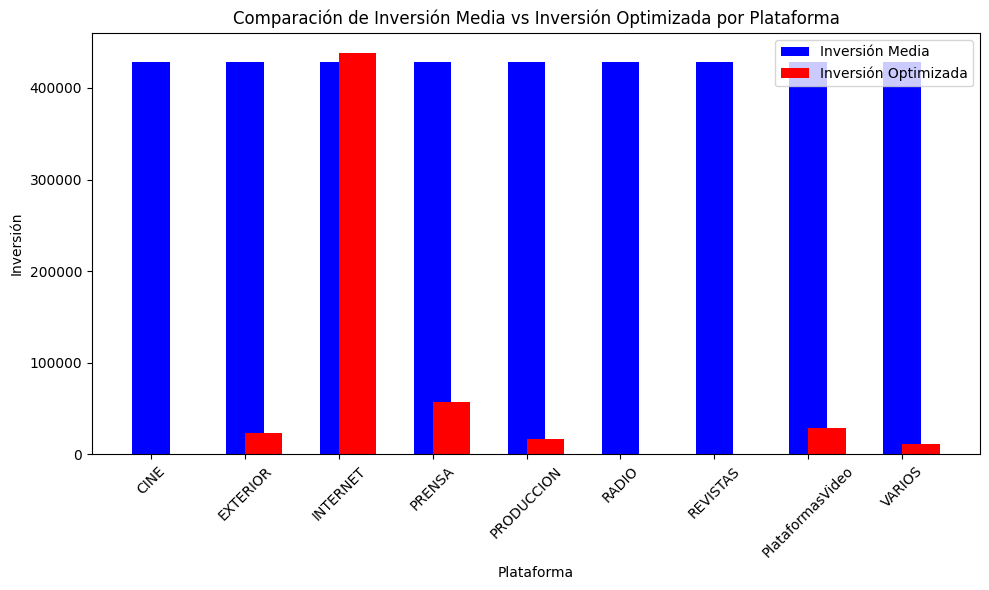

         Plataforma  Inversión_Media  Inversión_Optimizada  \
0              CINE    428356.559028                  0.00   
1          EXTERIOR    428356.559028              23062.48   
2          INTERNET    428356.559028             438187.16   
3            PRENSA    428356.559028              57656.21   
4        PRODUCCION    428356.559028              17296.86   
5             RADIO    428356.559028                  0.00   
6          REVISTAS    428356.559028                  0.00   
7  PlataformasVideo    428356.559028              28828.11   
8            VARIOS    428356.559028              11531.24   

   Ganancias_Proyectadas  
0                  0.000  
1               4612.496  
2              87637.432  
3              11531.242  
4               3459.372  
5                  0.000  
6                  0.000  
7               5765.622  
8               2306.248  


In [241]:
# Crear un DataFrame para la inversión optimizada
optimized_investment_df = pd.DataFrame({
    'Plataforma': platforms,
    'Inversión_Optimizada': [optimized_investment[platform] for platform in platforms],
    'Ganancias_Proyectadas': [optimized_investment[platform] * 0.2 for platform in platforms]  # Asumiendo un margen de beneficio del 20%
})

# Unir los datos de inversión media y optimizada
investment_comparison_df = pd.merge(average_investment_df, optimized_investment_df, on='Plataforma')

# Graficar la comparación entre inversión media y optimizada
plt.figure(figsize=(10, 6))
plt.bar(investment_comparison_df['Plataforma'], investment_comparison_df['Inversión_Media'], width=0.4, label='Inversión Media', align='center', color='blue')
plt.bar(investment_comparison_df['Plataforma'], investment_comparison_df['Inversión_Optimizada'], width=0.4, label='Inversión Optimizada', align='edge', color='red')
plt.xlabel('Plataforma')
plt.ylabel('Inversión')
plt.title('Comparación de Inversión Media vs Inversión Optimizada por Plataforma')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Mostrar la tabla con las ganancias proyectadas
print(investment_comparison_df[['Plataforma', 'Inversión_Media', 'Inversión_Optimizada', 'Ganancias_Proyectadas']])


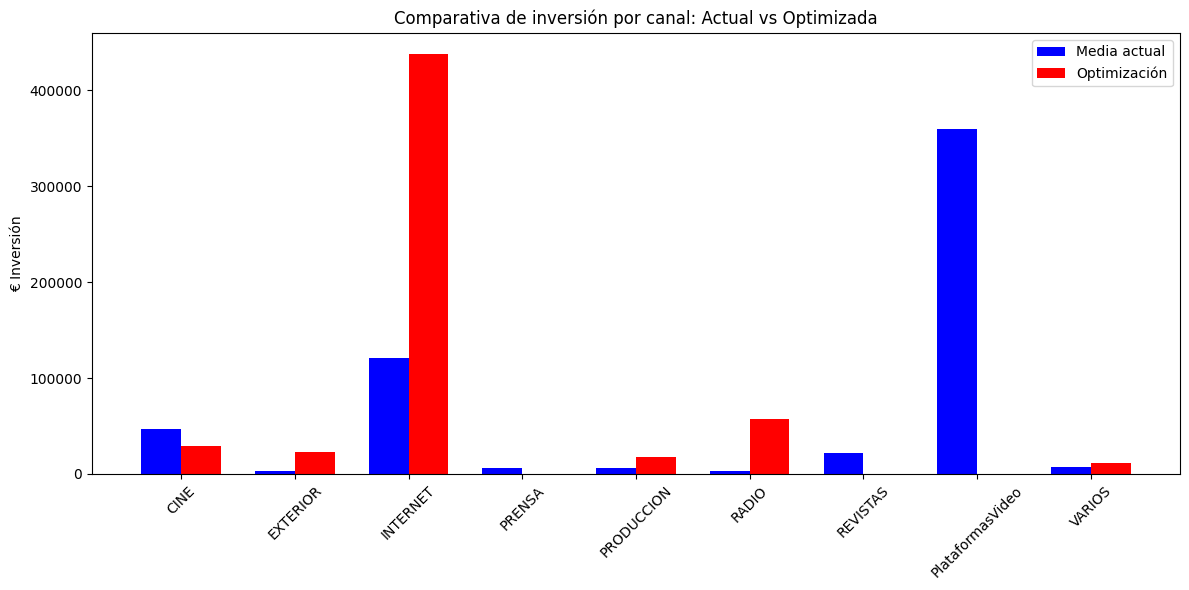

In [242]:
import matplotlib.pyplot as plt
import numpy as np

# Lista de las plataformas de inversión (canales)
variables_inversion = ['CINE', 'EXTERIOR', 'INTERNET', 'PRENSA', 'PRODUCCION', 'RADIO', 'REVISTAS', 'PlataformasVideo', 'VARIOS']

# Media de gasto actual por canal (tomado del DataFrame combinado)
media_inversion_actual = df_combined[variables_inversion].mean().values

# Inversión óptima (calculada previamente con el modelo de optimización)
inversion_optima = res.x  # Suponiendo que 'res.x' es el resultado optimizado

# Crear gráfico de barras comparativo
x = np.arange(len(variables_inversion))  # posiciones para las barras
width = 0.35  # Ancho de las barras

# Configuración de la figura
plt.figure(figsize=(12, 6))

# Barras de inversión media actual
plt.bar(x - width/2, media_inversion_actual, width, label='Media actual', color='blue')

# Barras de inversión optimizada
plt.bar(x + width/2, inversion_optima, width, label='Optimización', color='red')

# Etiquetas y título
plt.xticks(x, variables_inversion, rotation=45)
plt.ylabel("€ Inversión")
plt.title("Comparativa de inversión por canal: Actual vs Optimizada")
plt.legend()

# Ajuste de los márgenes para que no se corten las etiquetas
plt.tight_layout()

# Mostrar gráfico
plt.show()


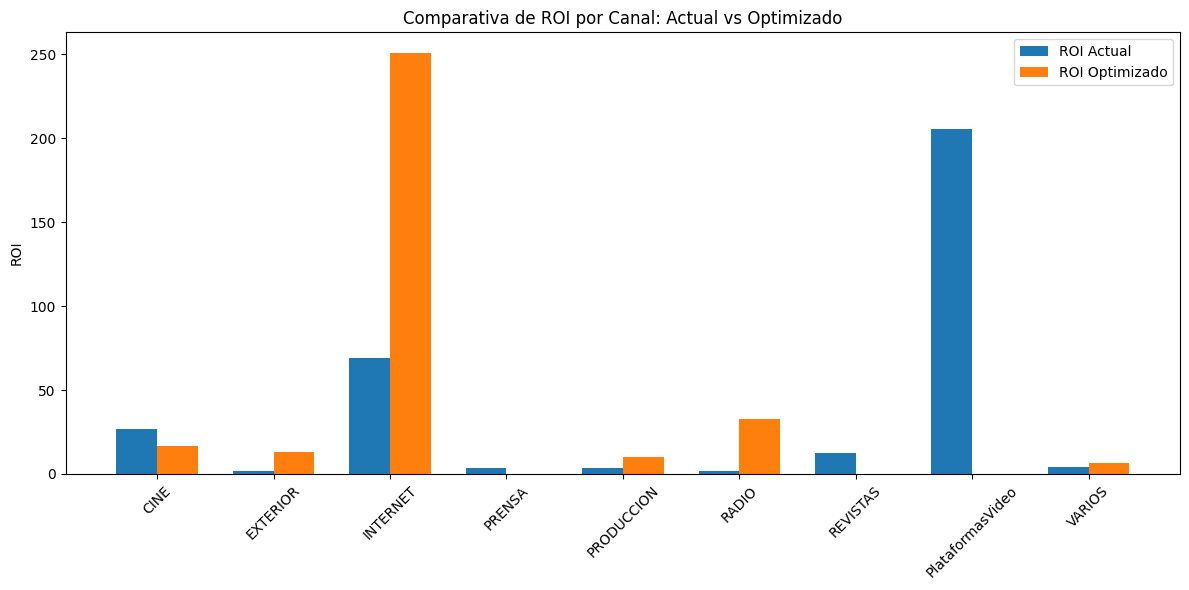

In [252]:
# Calcular el ROI actual
roi_actual = df_combined[variables_inversion].mean() / df_combined['Sales'].mean()

# Calcular el ROI optimizado (con la inversión optimizada)
roi_optimizado = inversion_optima / df_combined['Sales'].mean()

# Crear gráfico comparativo de ROI
x = np.arange(len(variables_inversion))  # posiciones
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, roi_actual, width, label='ROI Actual')
plt.bar(x + width/2, roi_optimizado, width, label='ROI Optimizado')

plt.xticks(x, variables_inversion, rotation=45)
plt.ylabel("ROI")
plt.title("Comparativa de ROI por Canal: Actual vs Optimizado")
plt.legend()
plt.tight_layout()
plt.show()


In [253]:
# 5

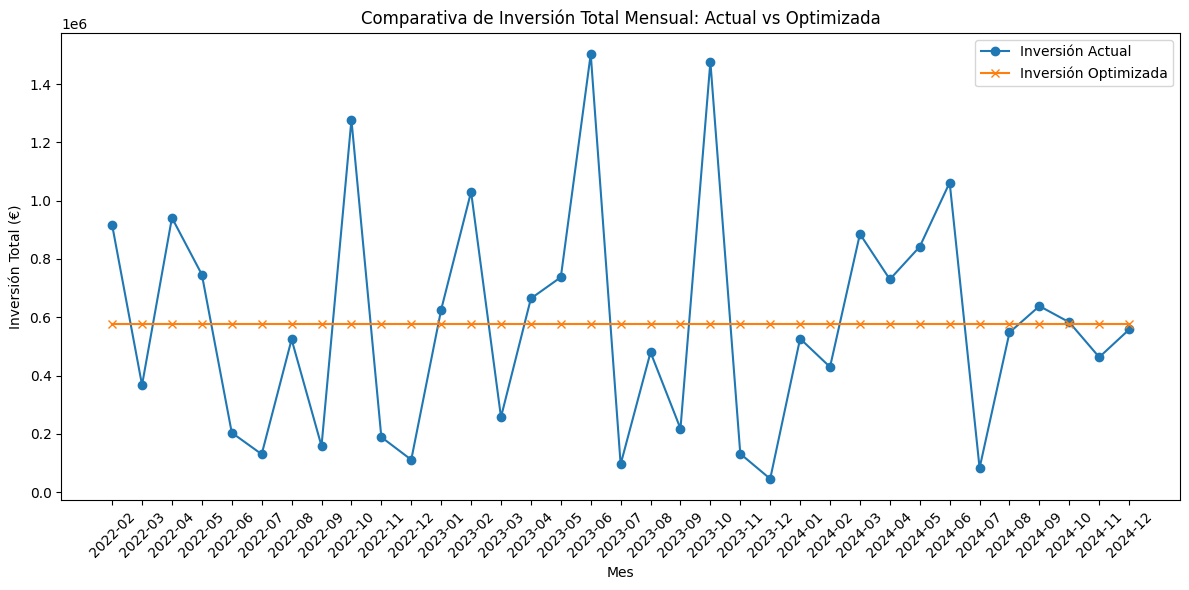

In [254]:
# Sumar la inversión total mensual actual
inversion_total_actual = df_combined.groupby(df_combined['Fecha'].dt.to_period('M'))[variables_inversion].sum().sum(axis=1)

# Sumar la inversión total mensual optimizada
inversion_total_optima = np.sum(inversion_optima) * np.ones(len(inversion_total_actual))

# Graficar la inversión mensual total
plt.figure(figsize=(12, 6))
plt.plot(inversion_total_actual.index.astype(str), inversion_total_actual.values, label='Inversión Actual', marker='o')
plt.plot(inversion_total_actual.index.astype(str), inversion_total_optima, label='Inversión Optimizada', marker='x')

plt.xlabel('Mes')
plt.ylabel('Inversión Total (€)')
plt.title('Comparativa de Inversión Total Mensual: Actual vs Optimizada')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
